In [1]:
import os
import gc
import time
import numpy as np; np.random.seed(42)
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster
from tsforest.utils import make_time_range
from tsforest.metrics import compute_rmse

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator

def trimean(array, axis=0):
    quantiles = np.percentile(array, [25, 50, 75], axis=axis)
    return (quantiles[0,:] + 2*quantiles[1,:] + quantiles[2,:])/4

SEEDS = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
# validation period to be used for test in all this notebook
valid_period = (pd.to_datetime("2016-03-28"), pd.to_datetime("2016-04-24"))

***
# Level 12

In [4]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46796220 entries, 0 to 46796219
Data columns (total 40 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ts_id              int16         
 1   item_id            int16         
 2   dept_id            int8          
 3   cat_id             int8          
 4   store_id           int8          
 5   state_id           int8          
 6   y                  int16         
 7   ds                 datetime64[ns]
 8   snap_CA            int8          
 9   snap_TX            int8          
 10  snap_WI            int8          
 11  snap_CA_cum        int8          
 12  snap_TX_cum        int8          
 13  snap_WI_cum        int8          
 14  event_name_1       int8          
 15  event_type_1       int8          
 16  event_name_2       int8          
 17  event_type_2       int8          
 18  sell_price         float32       
 19  n_prices           float32       
 20  regular_price      flo

In [5]:
weights_level12 = pd.read_parquet("../input/weights_level12.parquet")
scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales_level12 = compute_scaling(scaling_input, agg_columns=["item_id","store_id"]).rename({"q":"s"}, axis=1)

In [6]:
# outlier removal
#remove_idx = data.query("ds.dt.month == 12 & ds.dt.day == 25").index
#data.drop(remove_idx, axis=0, inplace=True)

In [8]:
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':100000,
    'early_stopping_rounds':300,
    'max_bin': 127,
    'bin_construct_sample_cnt':6000000,
    'num_leaves': 2**10-1,
    'min_data_in_leaf': 2**11-1,
    'learning_rate': 0.05, 
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.9,
    #'feature_fraction_bynode':0.9,
    'bagging_fraction':0.66,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':7,
    'boost_from_average': False,
    'first_metric_only': True,
}

time_features = [
    "year",
    "month",
    "year_week",
    #"year_day",
    "week_day",
    "month_progress", 
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    #"year_week_cos",
    #"year_week_sin",
    #"month_cos",
    #"month_sin"
]

exclude_features = [
    "ts_id",
    "event_type_1",
    "event_name_2",
    "event_type_2"]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    #"lags": list(range(1,15)),
    "window_shifts":[1,7,28],
    "window_functions":["mean","std","kurt"],
    "window_sizes":[7,28],
    "exclude_features":exclude_features,
    "categorical_features":{
        "item_id":"default",
        "dept_id":"default",
        "cat_id":"default",
        "store_id":"default",
        "state_id":"default",
        "event_name_1":"default",
    },
    "ts_uid_columns":["item_id","store_id"]
}

#lag_features = [f"lag{lag}" for lag in model_kwargs["lags"]]
rw_features = [f"{window_func}{window_size}_shift{window_shift}" 
               for window_func in model_kwargs["window_functions"]
               for window_size in model_kwargs["window_sizes"]
               for window_shift in model_kwargs["window_shifts"]]
#lagged_features = lag_features+rw_features
lagged_features = rw_features
lagged_features_to_dropna = [feat for feat in lagged_features if "kurt" not in feat]

***

In [ ]:
%%time

def bias_corr_func(x):
    x[x < 0.1] = 0
    return x

print("#"*100)
print(f" Validation period: {valid_period} ".center(100, "#"))
print("#"*100)

valid_start = valid_period[0]
valid_end = valid_period[1]
_train_data = data.query("ds <= @valid_end").reset_index(drop=True)
_valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

model_level12 = LightGBMForecaster(**model_kwargs)
model_level12.prepare_features(train_data=_train_data, valid_index=_valid_index);
model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
model_level12.train_features = reduce_mem_usage(model_level12.train_features)
model_level12.valid_features = reduce_mem_usage(model_level12.valid_features)
ts_id_in_train = model_level12.train_features.ts_id.unique()
model_level12.valid_features = model_level12.valid_features.query("ts_id in @ts_id_in_train")

# needed to remove leakage of 'no_stock' feature
no_stock_ts = list()
for threshold in [28, 56, 84, 112, 140, 168]:
    left_date = model_level12.train_features.ds.max() - pd.DateOffset(days=threshold)
    no_stock_ts.append((model_level12.train_features
                        .query("ds >= @left_date")
                        .groupby(["ts_id"])
                        .filter(lambda x: np.all(x.y==0))
                        .loc[:, ["ts_id"]]
                        .drop_duplicates()))
model_level12.valid_features["no_stock"] = 0
for j,no_stock in enumerate(no_stock_ts):
    idx = model_level12.valid_features.query("ts_id in @no_stock.ts_id").index
    model_level12.valid_features.loc[idx, "no_stock"] = j+1

print("Fitting the model")
tic = time.time()
evaluator = Evaluator(model_level12.valid_features)
model_level12.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")


lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,8))
lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,8))

valid_dataframe = (model_level12.valid_features
                   .loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]]
                   .copy())
evaluator = WRMSSEEvaluator(valid_dataframe)

print("Predicting with ground thruth lagged values")
tic = time.time()
forecast_f4_v0 = (model_level12.valid_features
                  .loc[:, ["ds"]+model_level12.ts_uid_columns]
                  .assign(y_pred = model_level12.model.predict(model_level12.valid_features)))
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

wrmsse = evaluator._evaluate(forecast_f4_v0.y_pred.values)
print("\nwrmsse:", wrmsse)
print(evaluator.errors_by_level)

print("Predicting with recursive approach")
tic = time.time()
valid_data = model_level12.valid_features.loc[:, model_level12.raw_train_columns].drop("y", axis=1)
forecast_f4_v1 = model_level12.predict(valid_data, recursive=True, bias_corr_func=bias_corr_func)
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

wrmsse = evaluator._evaluate(forecast_f4_v1.y_pred.values)
print("\nwrmsse:", wrmsse)
print(evaluator.errors_by_level)

mrg = (model_level12.valid_features.groupby(["ds"])["y"].sum().reset_index()
       .merge(forecast_f4_v0.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds")
       .merge(forecast_f4_v1.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
plt.figure(figsize=(15,5))
plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
plt.plot_date(mrg.ds, mrg.y_pred_x, "o-", label="pred_v0")
plt.plot_date(mrg.ds, mrg.y_pred_y, "o-", label="pred_v1")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

gc.collect()

####################################################################################################
##### Validation period: (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00')) ######
####################################################################################################
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 4.194215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6823
[LightGBM] [Info] Number of data points in the train set: 43411937, number of used features: 57
Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsseL12: 0.910802	valid_0's wrmsse: 1.01835
[50]	valid_0's wrmsseL12: 0.83821	valid_0's wrmsse: 0.59845
[75]	valid_0's wrmsseL12: 0.82944	valid_0's wrmsse: 0.52671
[100]	valid_0's wrmsseL12: 0.827163	valid_0's wrmsse: 0.505264
[125]	valid_0'

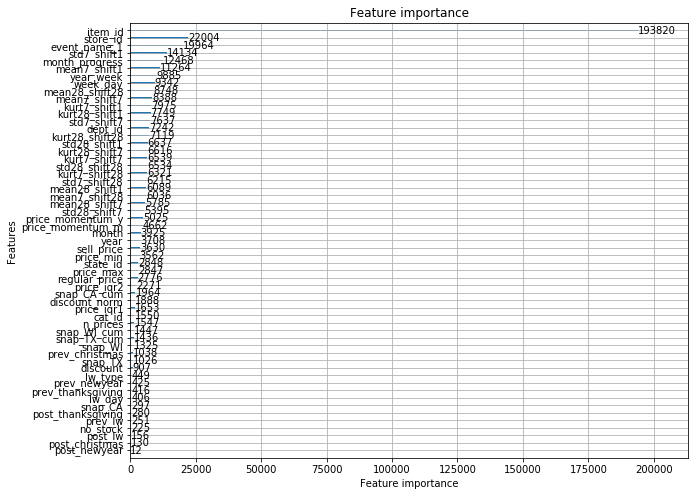

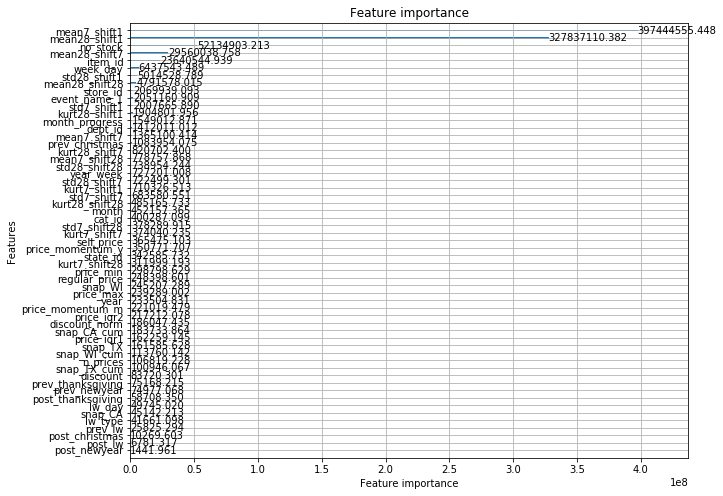

In [21]:
lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,8))
lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,8))

In [18]:
wrmsse = evaluator._evaluate(forecast_f4_v0.y_pred.values)
print("\nwrmsse:", wrmsse)
print(evaluator.errors_by_level)


wrmsse: 0.5027189527149184
{'root': 0.2956348368935414, ('state_id',): 0.34266629668976156, ('store_id',): 0.4143207427113427, ('cat_id',): 0.3341395667750202, ('dept_id',): 0.394936278562915, ('state_id', 'cat_id'): 0.39359369065874644, ('state_id', 'dept_id'): 0.45754279557049793, ('store_id', 'cat_id'): 0.479911001146174, ('store_id', 'dept_id'): 0.5416651411062818, ('item_id',): 0.7581603880779119, ('item_id', 'state_id'): 0.7956428419115953, ('item_id', 'store_id'): 0.8244138524752326}


In [19]:
print("Predicting with recursive approach")
tic = time.time()
valid_data = model_level12.valid_features.loc[:, model_level12.raw_train_columns].drop("y", axis=1)
forecast_f4_v1 = model_level12.predict(valid_data, recursive=True, bias_corr_func=bias_corr_func)
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

Predicting with recursive approach
Elapsed time: 8.557670072714489 [min]


In [20]:
wrmsse = evaluator._evaluate(forecast_f4_v1.y_pred.values)
print("\nwrmsse:", wrmsse)
print(evaluator.errors_by_level)


wrmsse: 0.662600385949638
{'root': 0.5820867341861283, ('state_id',): 0.5763530520791572, ('store_id',): 0.6193211849387684, ('cat_id',): 0.5751759198677902, ('dept_id',): 0.5850392904299836, ('state_id', 'cat_id'): 0.5781108030130286, ('state_id', 'dept_id'): 0.6100144275558015, ('store_id', 'cat_id'): 0.6386038544837493, ('store_id', 'dept_id'): 0.6617742780188499, ('item_id',): 0.823509586048622, ('item_id', 'state_id'): 0.8430374582261949, ('item_id', 'store_id'): 0.8581780425475821}


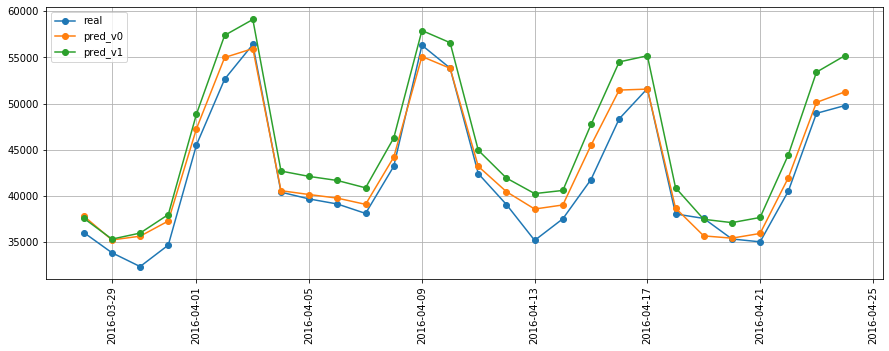

In [22]:
mrg = (model_level12.valid_features.groupby(["ds"])["y"].sum().reset_index()
       .merge(forecast_f4_v0.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds")
       .merge(forecast_f4_v1.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
plt.figure(figsize=(15,5))
plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
plt.plot_date(mrg.ds, mrg.y_pred_x, "o-", label="pred_v0")
plt.plot_date(mrg.ds, mrg.y_pred_y, "o-", label="pred_v1")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

***

In [23]:
from supersmoother import SuperSmoother
from tsforest.utils import make_time_range

class TrendModel():
    
    def __init__(self, window_length, alpha=None):
        self.window_length = window_length
        self.alpha = alpha
        self.primary_span_lower = 1
        self.primary_span_upper = 3
        self.middle_span = 3
        self.upper_span = 2
    
    def fit(self, data):
        min_date = data.ds.min()
        time_idx = (data.ds - min_date).apply(lambda x: x.days).values
        values = data.y.values 
        win = self.window_length / (max(time_idx)-min(time_idx)) 
        
        trend_model = SuperSmoother(
            alpha=self.alpha,
            primary_spans=(self.primary_span_lower * win,
                           win,
                           self.primary_span_upper * win),
            middle_span=self.middle_span * win,
            final_span=self.upper_span * win)
        trend_model.fit(time_idx, values)
        
        self.min_date = min_date
        self.trend_model = trend_model
    
    def predict(self, data):
        time_idx = (data.ds - self.min_date).apply(lambda x: x.days).values
        predictions = self.trend_model.predict(time_idx)
        return pd.DataFrame({"ds":data.ds.values, "trend":predictions})  

In [28]:
data_l1 = data.groupby(["ds"])["y"].sum().reset_index().query("ds <= '2016-04-24'")

In [35]:
fcst_l1 = forecast_f4_v1.groupby(["ds"])["y_pred"].sum().reset_index()

In [29]:
predict_tr = make_time_range("2016-03-28", "2016-04-24", "D")

In [57]:
tmodel1 = TrendModel(window_length=30, alpha=1)
tmodel1.fit(data_l1)
trend_dataframe1 = tmodel1.predict(predict_tr)

In [67]:
tmodel2 = TrendModel(window_length=30, alpha=1)
tmodel2.fit(data_l1.query("ds < '2016-03-28'"))
trend_dataframe2 = tmodel2.predict(predict_tr)

In [68]:
tmodel3 = TrendModel(window_length=50, alpha=1)
tmodel3.fit(pd.concat([data_l1.query("ds < '2016-03-28'"), fcst_l1.rename({"y_pred":"y"}, axis=1)], ignore_index=True))
trend_dataframe3 = tmodel3.predict(predict_tr)

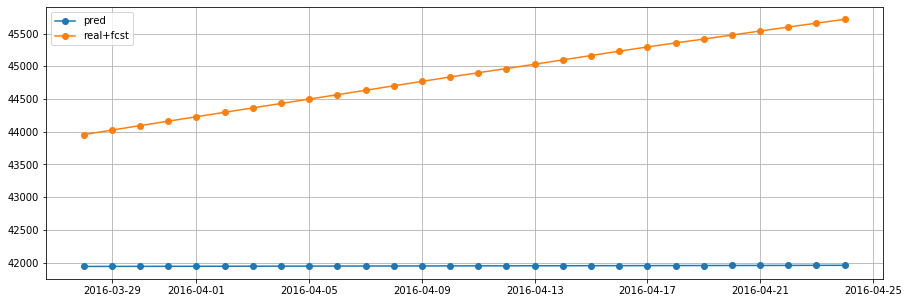

In [69]:
plt.figure(figsize=(15,5))
#plt.plot_date(trend_dataframe1.ds, trend_dataframe1.trend, "o-", label="real")
plt.plot_date(trend_dataframe2.ds, trend_dataframe2.trend, "o-", label="pred")
plt.plot_date(trend_dataframe3.ds, trend_dataframe3.trend, "o-", label="real+fcst")
plt.grid()
plt.legend(loc="best")
plt.show()

In [56]:
mrg.eval("y_pred_y - y").mean()

3156.199827882665